# MODELO 4 - CGAN para generar una imagen del CIFAR-100 a pedido del usuario

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
print(tf.__version__)

2.13.0


- Importo las librerias neceasarias

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar100
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Embedding, Concatenate
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset

In [4]:
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]

print(img_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

32
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

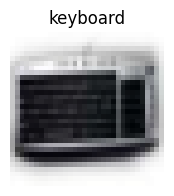

In [5]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

# Construcción del generador

In [ ]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa

    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 256 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = Reshape((img_size_in, img_size_in, 256), name='Generator_Reshape')(gen) # Cambio la forma de la capa
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li]) # Concateno las capas
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 16x16x256
    gen = BatchNormalization(name='Generator_BatchNormalization_1')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 32x32x128
    gen = BatchNormalization(name='Generator_BatchNormalization_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', name='Conv2DTranspose_3')(gen)  # 32x32x64
    gen = BatchNormalization(name='Generator_BatchNormalization_3')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_3')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2D(3, (8, 8), activation='tanh', padding='same', name='Output_Conv2D_1')(gen)  # 32x32x3
    #---------------------------------------------------------------------------------#

    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='/content/drive/MyDrive/Lembo/generator_structure_m4_cifar100.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [ ]:
def build_discriminator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size
    li = Dense(n_nodes, name='Label_Dense')(li)
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li)

    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input')
    in_image = Dropout(0.75, name='Dropout')(in_image)
    merge = Concatenate(name='Concatenate')([in_image, li])
    #---------------------------------------------------------------------------------#
    fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='Conv2D_1')(merge) # 16x16x32
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2')(fe) # 8x8x64
    fe = BatchNormalization(name='Generator_BatchNormalization_1')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2D_3')(fe) # 4x4x128
    fe = BatchNormalization(name='Generator_BatchNormalization_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(256, (5, 5), strides=(2, 2), padding='same', name='Conv2D_4')(fe) # 2x2x256
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    out_layer = Dense(1, activation='sigmoid', name='Output_Dense')(fe)
    #---------------------------------------------------------------------------------#

    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='/content/drive/MyDrive/Lembo/discriminator_structure_m4_cifar100.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [ ]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("/content/drive/MyDrive/Lembo/evolution_m4_cifar100", exist_ok=True)
  plt.savefig(f"/content/drive/MyDrive/Lembo/evolution_m4_cifar100/images_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [ ]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [ ]:
epoch_count = 50 # Cantidad de epocas
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [ ]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Latent_Input (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                5000      ['Label_Input[0][0]']         
                                                                                                  
 Generator_Dense (Dense)     (None, 16384)                1654784   ['Latent_Input[0][0]']        
                                                                                          

- Construyo el discriminador

In [ ]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                5000      ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 1024)              52224     ['Embedding[1][0]']           
                                                                                                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [ ]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = g_model([noise, real_labels], training = True) #  Genero imagenes falsas
            pred_real = d_model([real_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes reales
            pred_fake = d_model([generated_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes falsas

            g_loss = generator_loss(pred_fake) # Calculo la loss del generador
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        grads_g = gen_tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        grads_d = disc_tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes

        g_optimizer.apply_gradients(zip(grads_g, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador
        d_optimizer.apply_gradients(zip(grads_d, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [ ]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([noise, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        g_loss = generator_loss(pred_fake) # Calculo la loss del generador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [ ]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    num_train_batches = len(train_dataset)
    num_test_batches = len(test_dataset)

    d_loss_list_epoch_train = np.zeros(epoch_count)
    g_loss_list_epoch_train = np.zeros(epoch_count)
    d_loss_list_epoch_test = np.zeros(epoch_count)
    g_loss_list_epoch_test = np.zeros(epoch_count)
    precision_list_epoch_train = np.zeros(epoch_count)
    recall_list_epoch_train = np.zeros(epoch_count)
    f1_list_epoch_train = np.zeros(epoch_count)
    accuracy_list_epoch_train = np.zeros(epoch_count)
    precision_list_epoch_test = np.zeros(epoch_count)
    recall_list_epoch_test = np.zeros(epoch_count)
    f1_list_epoch_test = np.zeros(epoch_count)
    accuracy_list_epoch_test = np.zeros(epoch_count)
    d_loss_list_itern_train = np.zeros(epoch_count *num_train_batches)
    g_loss_list_itern_train = np.zeros(epoch_count * num_train_batches)
    d_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)
    g_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)

    itern_train_counter = 0
    itern_test_counter = 0

    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)

        d_loss_list_batch_train_aux = np.zeros(num_train_batches)
        g_loss_list_batch_train_aux = np.zeros(num_train_batches)
        d_loss_list_batch_test_aux = np.zeros(num_test_batches)
        g_loss_list_batch_test_aux = np.zeros(num_test_batches)
        precision_list_batch_train = np.zeros(num_train_batches)
        recall_list_batch_train = np.zeros(num_train_batches)
        f1_list_batch_train = np.zeros(num_train_batches)
        accuracy_list_batch_train = np.zeros(num_train_batches)
        precision_list_batch_test = np.zeros(num_test_batches)
        recall_list_batch_test = np.zeros(num_test_batches)
        f1_list_batch_test = np.zeros(num_test_batches)
        accuracy_list_batch_test = np.zeros(num_test_batches)

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento

            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux[itern] = d_loss_train
            g_loss_list_batch_train_aux[itern] = g_loss_train
            d_loss_list_itern_train[itern_train_counter] = d_loss_train
            g_loss_list_itern_train[itern_train_counter] = g_loss_train
            itern_train_counter += 1

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,)) # Reshapeo para que all_pred_labels_train (tiene la dimensión de la salida del discriminador) tenga la misma forma que all_real_labels_train

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train[itern] = precision_train
            recall_list_batch_train[itern] = recall_train
            f1_list_batch_train[itern] = f1_train
            accuracy_list_batch_train[itern] = accuracy_train
            itern=itern+1

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo

            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux[itern] = d_loss_test
            g_loss_list_batch_test_aux[itern] = g_loss_test
            d_loss_list_itern_test[itern_test_counter] = d_loss_test
            g_loss_list_itern_test[itern_test_counter] = g_loss_test
            itern_test_counter += 1

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test[itern] = precision_test
            recall_list_batch_test[itern] = recall_test
            f1_list_batch_test[itern] = f1_test
            accuracy_list_batch_test[itern] = accuracy_test

            itern=itern+1

        d_loss_list_epoch_train[epoch] = np.mean(d_loss_list_batch_train_aux)
        g_loss_list_epoch_train[epoch] = np.mean(g_loss_list_batch_train_aux)
        d_loss_list_epoch_test[epoch] = np.mean(d_loss_list_batch_test_aux)
        g_loss_list_epoch_test[epoch] = np.mean(g_loss_list_batch_test_aux)
        precision_list_epoch_train[epoch] = np.mean(precision_list_batch_train)
        recall_list_epoch_train[epoch] = np.mean(recall_list_batch_train)
        f1_list_epoch_train[epoch] = np.mean(f1_list_batch_train)
        accuracy_list_epoch_train[epoch] = np.mean(accuracy_list_batch_train)
        precision_list_epoch_test[epoch] = np.mean(precision_list_batch_test)
        recall_list_epoch_test[epoch] = np.mean(recall_list_batch_test)
        f1_list_epoch_test[epoch] = np.mean(f1_list_batch_test)
        accuracy_list_epoch_test[epoch] = np.mean(accuracy_list_batch_test)

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_itern_train, g_loss_itern_train, d_loss_itern_test, g_loss_itern_test, d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz", epochs= epochs, d_loss_itern_train=d_loss_itern_train, g_loss_itern_train=g_loss_itern_train, d_loss_itern_test=d_loss_itern_test, g_loss_itern_test=g_loss_itern_test, d_loss_train=d_loss_train, g_loss_train=g_loss_train, d_loss_test=d_loss_test, g_loss_test=g_loss_test, precision_train=precision_train, recall_train=recall_train, f1_train=f1_train, accuracy_train=accuracy_train, precision_test=precision_test, recall_test=recall_test, f1_test=f1_test, accuracy_test=accuracy_test)
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m4_cifar100.keras")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m4_cifar100.keras")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m4_cifar100.h5")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m4_cifar100.h5")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m4_cifar100.tf")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m4_cifar100.tf")

Epoch:  1


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 78.33it/s]


Train - Época: 1 -- Generator Loss: 0.8357428167544305, Discriminator Loss: 1.4074282504558564
Test - Época: 1 -- Generator Loss: 0.6412031804561615, Discriminator Loss: 1.403487084197998

Tomó 69.00228023529053 segundos. 


1/1 [==============================] - 0s 20ms/step
Epoch:  2


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.68it/s]


Train - Época: 2 -- Generator Loss: 1.2427716047787667, Discriminator Loss: 1.1132584952449798
Test - Época: 2 -- Generator Loss: 0.38526609814167023, Discriminator Loss: 1.646725562286377

Tomó 57.40688610076904 segundos. 


Epoch:  3


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.19it/s]


Train - Época: 3 -- Generator Loss: 1.3651241734910011, Discriminator Loss: 1.0614654234552383
Test - Época: 3 -- Generator Loss: 0.575438841342926, Discriminator Loss: 1.402078286743164

Tomó 57.885656118392944 segundos. 


Epoch:  4


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.16it/s]


Train - Época: 4 -- Generator Loss: 1.7375532644844056, Discriminator Loss: 0.9259064236855507
Test - Época: 4 -- Generator Loss: 1.4026296553611755, Discriminator Loss: 1.3729515064239501

Tomó 57.10254096984863 segundos. 


Epoch:  5


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.40it/s]


Train - Época: 5 -- Generator Loss: 2.034848778516054, Discriminator Loss: 0.8362137574887276
Test - Época: 5 -- Generator Loss: 0.36958004155158997, Discriminator Loss: 1.8159557556152344

Tomó 56.71521234512329 segundos. 


Epoch:  6


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.54it/s]


Train - Época: 6 -- Generator Loss: 2.1426437083148957, Discriminator Loss: 0.8116948217964173
Test - Época: 6 -- Generator Loss: 0.9016601281166077, Discriminator Loss: 1.2478537380218506

Tomó 56.838356733322144 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  7


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.83it/s]


Train - Época: 7 -- Generator Loss: 2.0585571687722206, Discriminator Loss: 0.8350354683041572
Test - Época: 7 -- Generator Loss: 1.1379809665679932, Discriminator Loss: 1.2416878998756409

Tomó 56.68239760398865 segundos. 


Epoch:  8


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.36it/s]


Train - Época: 8 -- Generator Loss: 2.1480962336587908, Discriminator Loss: 0.8006204253774881
Test - Época: 8 -- Generator Loss: 0.7243120635509491, Discriminator Loss: 1.310691711139679

Tomó 56.63101530075073 segundos. 


Epoch:  9


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 87.74it/s]


Train - Época: 9 -- Generator Loss: 2.189475535132885, Discriminator Loss: 0.7946338184142113
Test - Época: 9 -- Generator Loss: 0.6461002827167511, Discriminator Loss: 1.4323117761611939

Tomó 56.91001605987549 segundos. 


Epoch:  10


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 87.85it/s]


Train - Época: 10 -- Generator Loss: 2.14076810773015, Discriminator Loss: 0.8064590147686005
Test - Época: 10 -- Generator Loss: 0.827382309961319, Discriminator Loss: 1.3453898125648498

Tomó 56.86642336845398 segundos. 


Epoch:  11


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 87.93it/s]


Train - Época: 11 -- Generator Loss: 2.1408103271698953, Discriminator Loss: 0.8046580900001525
Test - Época: 11 -- Generator Loss: 1.2217842260360718, Discriminator Loss: 1.259012711429596

Tomó 56.80958151817322 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  12


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 87.89it/s]


Train - Época: 12 -- Generator Loss: 2.2559939324343206, Discriminator Loss: 0.7763329069787264
Test - Época: 12 -- Generator Loss: 0.5695173128604889, Discriminator Loss: 1.523596211051941

Tomó 56.63555550575256 segundos. 


Epoch:  13


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.62it/s]


Train - Época: 13 -- Generator Loss: 2.217144630874395, Discriminator Loss: 0.7895221472173929
Test - Época: 13 -- Generator Loss: 1.3968351761817932, Discriminator Loss: 1.200270006275177

Tomó 56.57253646850586 segundos. 


Epoch:  14


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.15it/s]


Train - Época: 14 -- Generator Loss: 2.2850771746659277, Discriminator Loss: 0.7685985963124037
Test - Época: 14 -- Generator Loss: 1.5124723962783813, Discriminator Loss: 1.3553659407615661

Tomó 56.772764444351196 segundos. 


Epoch:  15


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.31it/s]


Train - Época: 15 -- Generator Loss: 2.226258840173483, Discriminator Loss: 0.7821181595110893
Test - Época: 15 -- Generator Loss: 1.4308974395751952, Discriminator Loss: 1.4084908514976502

Tomó 56.64205622673035 segundos. 


Epoch:  16


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.25it/s]


Train - Época: 16 -- Generator Loss: 2.3049860404419897, Discriminator Loss: 0.7718985647332668
Test - Época: 16 -- Generator Loss: 1.4149013856887818, Discriminator Loss: 1.2870172770500183

Tomó 56.517518758773804 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  17


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.40it/s]


Train - Época: 17 -- Generator Loss: 2.2544677539002898, Discriminator Loss: 0.7748042876425385
Test - Época: 17 -- Generator Loss: 0.7160834785461426, Discriminator Loss: 1.367012595462799

Tomó 56.57398080825806 segundos. 


Epoch:  18


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.86it/s]


Train - Época: 18 -- Generator Loss: 2.2711895565372706, Discriminator Loss: 0.7770090856790542
Test - Época: 18 -- Generator Loss: 1.0757840101242064, Discriminator Loss: 1.200965387248993

Tomó 56.708322525024414 segundos. 


Epoch:  19


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.87it/s]


Train - Época: 19 -- Generator Loss: 2.327966548358202, Discriminator Loss: 0.7594608884763717
Test - Época: 19 -- Generator Loss: 0.42798828411102297, Discriminator Loss: 1.6862248626708984

Tomó 56.40220618247986 segundos. 


Epoch:  20


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.08it/s]


Train - Época: 20 -- Generator Loss: 2.316988156990409, Discriminator Loss: 0.7662586962831021
Test - Época: 20 -- Generator Loss: 1.273051310634613, Discriminator Loss: 1.316832900238037

Tomó 56.35894417762756 segundos. 


Epoch:  21


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 90.38it/s]


Train - Época: 21 -- Generator Loss: 2.2813354370391368, Discriminator Loss: 0.7684470355939865
Test - Época: 21 -- Generator Loss: 1.5920907742500305, Discriminator Loss: 1.3934884892463684

Tomó 56.45120048522949 segundos. 


1/1 [==============================] - 0s 20ms/step
Epoch:  22


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.54it/s]


Train - Época: 22 -- Generator Loss: 2.285323399620056, Discriminator Loss: 0.7640072467941046
Test - Época: 22 -- Generator Loss: 2.0987954471588135, Discriminator Loss: 1.6839575744628905

Tomó 56.78847670555115 segundos. 


Epoch:  23


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.23it/s]


Train - Época: 23 -- Generator Loss: 2.3245884988427163, Discriminator Loss: 0.7605069817283749
Test - Época: 23 -- Generator Loss: 1.015615322971344, Discriminator Loss: 1.285479008102417

Tomó 56.50195121765137 segundos. 


Epoch:  24


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.83it/s]


Train - Época: 24 -- Generator Loss: 2.4165420422333477, Discriminator Loss: 0.7378841871774197
Test - Época: 24 -- Generator Loss: 1.0252090341567994, Discriminator Loss: 1.3300247292518617

Tomó 56.45851731300354 segundos. 


Epoch:  25


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.98it/s]


Train - Época: 25 -- Generator Loss: 2.3686022410291434, Discriminator Loss: 0.7518123596727848
Test - Época: 25 -- Generator Loss: 1.1125980977058412, Discriminator Loss: 1.3040976337432861

Tomó 56.491878271102905 segundos. 


Epoch:  26


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.78it/s]


Train - Época: 26 -- Generator Loss: 2.4007506745260954, Discriminator Loss: 0.7411769923740625
Test - Época: 26 -- Generator Loss: 1.715698680114746, Discriminator Loss: 1.5759291040420533

Tomó 56.414271116256714 segundos. 


1/1 [==============================] - 0s 20ms/step
Epoch:  27


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.41it/s]


Train - Época: 27 -- Generator Loss: 2.449838001987934, Discriminator Loss: 0.7306428916192055
Test - Época: 27 -- Generator Loss: 0.6444319193363189, Discriminator Loss: 1.5738979448318482

Tomó 56.32878279685974 segundos. 


Epoch:  28


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 87.63it/s]


Train - Época: 28 -- Generator Loss: 2.4817846567726134, Discriminator Loss: 0.7163440704137087
Test - Época: 28 -- Generator Loss: 1.2338172914505006, Discriminator Loss: 1.2432470611572266

Tomó 56.5853431224823 segundos. 


Epoch:  29


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.76it/s]


Train - Época: 29 -- Generator Loss: 2.4634615000092985, Discriminator Loss: 0.7289419245231151
Test - Época: 29 -- Generator Loss: 1.298713030052185, Discriminator Loss: 1.365362564945221

Tomó 56.746365785598755 segundos. 


Epoch:  30


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.55it/s]


Train - Época: 30 -- Generator Loss: 2.5357626003348828, Discriminator Loss: 0.7115234378141165
Test - Época: 30 -- Generator Loss: 0.7613041426181794, Discriminator Loss: 1.4858978991508485

Tomó 56.689531564712524 segundos. 


Epoch:  31


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.13it/s]


Train - Época: 31 -- Generator Loss: 2.6410090364295242, Discriminator Loss: 0.693093312433809
Test - Época: 31 -- Generator Loss: 1.0922635527610778, Discriminator Loss: 1.3280944671630859

Tomó 56.243603229522705 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  32


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.77it/s]


Train - Época: 32 -- Generator Loss: 2.577353357620239, Discriminator Loss: 0.7021201899236441
Test - Época: 32 -- Generator Loss: 0.9047477253437042, Discriminator Loss: 1.3397485228538513

Tomó 56.4874382019043 segundos. 


Epoch:  33


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.94it/s]


Train - Época: 33 -- Generator Loss: 2.585064242781401, Discriminator Loss: 0.696895092060566
Test - Época: 33 -- Generator Loss: 0.8316869529724121, Discriminator Loss: 1.3959924595832824

Tomó 56.83646845817566 segundos. 


Epoch:  34


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.21it/s]


Train - Época: 34 -- Generator Loss: 2.6279807689809798, Discriminator Loss: 0.6860785579225421
Test - Época: 34 -- Generator Loss: 1.278208187866211, Discriminator Loss: 1.445334654712677

Tomó 56.71363544464111 segundos. 


Epoch:  35


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.20it/s]


Train - Época: 35 -- Generator Loss: 2.606499727521837, Discriminator Loss: 0.6934145746962727
Test - Época: 35 -- Generator Loss: 0.9464798995018006, Discriminator Loss: 1.3658903335571289

Tomó 56.552987813949585 segundos. 


Epoch:  36


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 87.77it/s]


Train - Época: 36 -- Generator Loss: 2.70463499630481, Discriminator Loss: 0.6767914586949348
Test - Época: 36 -- Generator Loss: 1.2745564977645873, Discriminator Loss: 1.3683665296554566

Tomó 56.9458703994751 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  37


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.52it/s]


Train - Época: 37 -- Generator Loss: 2.6507529571044444, Discriminator Loss: 0.6867531380981207
Test - Época: 37 -- Generator Loss: 1.2593866189956664, Discriminator Loss: 1.4245150546073913

Tomó 56.49714159965515 segundos. 


Epoch:  38


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.35it/s]


Train - Época: 38 -- Generator Loss: 2.692766223716736, Discriminator Loss: 0.6736263835646957
Test - Época: 38 -- Generator Loss: 0.6821923073291779, Discriminator Loss: 1.438279371070862

Tomó 56.41917657852173 segundos. 


Epoch:  39


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.87it/s]


Train - Época: 39 -- Generator Loss: 2.6543754318237305, Discriminator Loss: 0.677268058681488
Test - Época: 39 -- Generator Loss: 1.2860823197364808, Discriminator Loss: 1.3625698516845703

Tomó 56.44749307632446 segundos. 


Epoch:  40


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.82it/s]


Train - Época: 40 -- Generator Loss: 2.655155005250573, Discriminator Loss: 0.6807806131079048
Test - Época: 40 -- Generator Loss: 1.4800538883209229, Discriminator Loss: 1.4432848054885865

Tomó 56.84011459350586 segundos. 


Epoch:  41


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.49it/s]


Train - Época: 41 -- Generator Loss: 2.704965641812086, Discriminator Loss: 0.6682285076367855
Test - Época: 41 -- Generator Loss: 0.890594293308258, Discriminator Loss: 1.4142586904525756

Tomó 56.28023719787598 segundos. 


1/1 [==============================] - 0s 20ms/step
Epoch:  42


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.99it/s]


Train - Época: 42 -- Generator Loss: 2.7529887914562226, Discriminator Loss: 0.6604811071203649
Test - Época: 42 -- Generator Loss: 1.3754040389060973, Discriminator Loss: 1.4371883069038391

Tomó 56.50474405288696 segundos. 


Epoch:  43


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.39it/s]


Train - Época: 43 -- Generator Loss: 2.7954963803684714, Discriminator Loss: 0.654247719437182
Test - Época: 43 -- Generator Loss: 1.4540946381568909, Discriminator Loss: 1.3535000056266784

Tomó 56.4021520614624 segundos. 


Epoch:  44


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.61it/s]


Train - Época: 44 -- Generator Loss: 2.7794612822425364, Discriminator Loss: 0.6579944987365604
Test - Época: 44 -- Generator Loss: 1.3056042255401612, Discriminator Loss: 1.3542187452316283

Tomó 56.769344091415405 segundos. 


Epoch:  45


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.57it/s]


Train - Época: 45 -- Generator Loss: 2.807928358092904, Discriminator Loss: 0.6496528492692113
Test - Época: 45 -- Generator Loss: 1.227506994152069, Discriminator Loss: 1.4974185420036317

Tomó 56.47978210449219 segundos. 


Epoch:  46


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.34it/s]


Train - Época: 46 -- Generator Loss: 2.805394306563735, Discriminator Loss: 0.6540891354098916
Test - Época: 46 -- Generator Loss: 2.516423412513733, Discriminator Loss: 2.058183501243591

Tomó 56.61036825180054 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  47


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.36it/s]


Train - Época: 47 -- Generator Loss: 2.8697543009054662, Discriminator Loss: 0.64257622122854
Test - Época: 47 -- Generator Loss: 1.3081309918403625, Discriminator Loss: 1.4352813344955444

Tomó 56.582393646240234 segundos. 


Epoch:  48


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 89.28it/s]


Train - Época: 48 -- Generator Loss: 2.8745823854404686, Discriminator Loss: 0.634652294984758
Test - Época: 48 -- Generator Loss: 0.5613792774677276, Discriminator Loss: 1.73143463306427

Tomó 56.45189118385315 segundos. 


Epoch:  49


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 88.93it/s]


Train - Época: 49 -- Generator Loss: 2.8017472302654385, Discriminator Loss: 0.6549696738444268
Test - Época: 49 -- Generator Loss: 0.7478066150665283, Discriminator Loss: 1.4829713295936584

Tomó 56.797457218170166 segundos. 


Epoch:  50


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 89.55it/s]


Train - Época: 50 -- Generator Loss: 2.8654560369437934, Discriminator Loss: 0.6410673915739358
Test - Época: 50 -- Generator Loss: 1.327283487224579, Discriminator Loss: 1.4429345750808715

Tomó 56.68857383728027 segundos. 




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

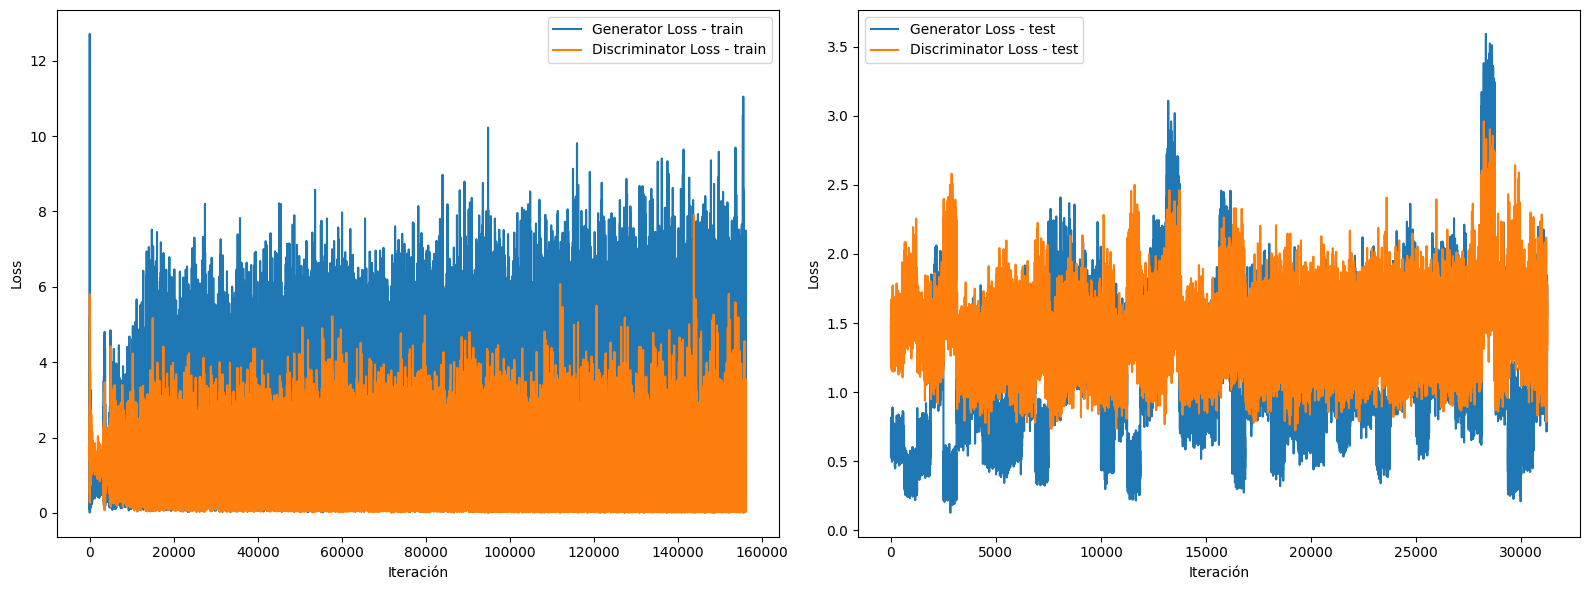

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_itern_train = data['d_loss_itern_train']
g_loss_itern_train = data['g_loss_itern_train']
d_loss_itern_test = data['d_loss_itern_test']
g_loss_itern_test = data['g_loss_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

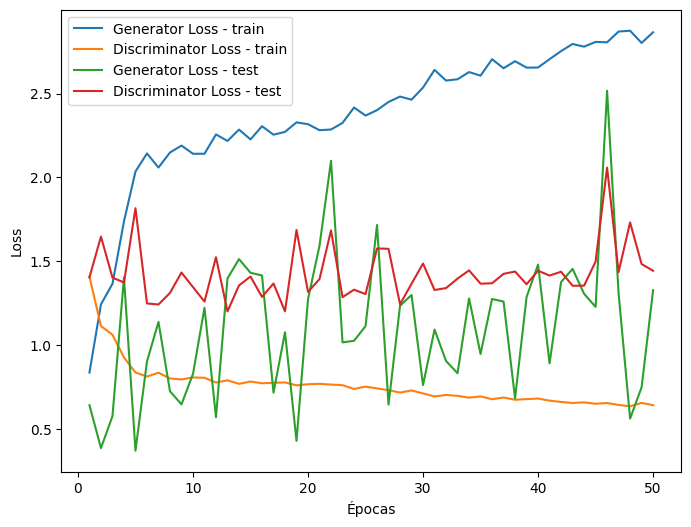

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz")

epochs = data['epochs']
d_loss_train = data['d_loss_train']
g_loss_train = data['g_loss_train']
d_loss_test = data['d_loss_test']
g_loss_test = data['g_loss_test']

plt.figure(figsize=(8,6))
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

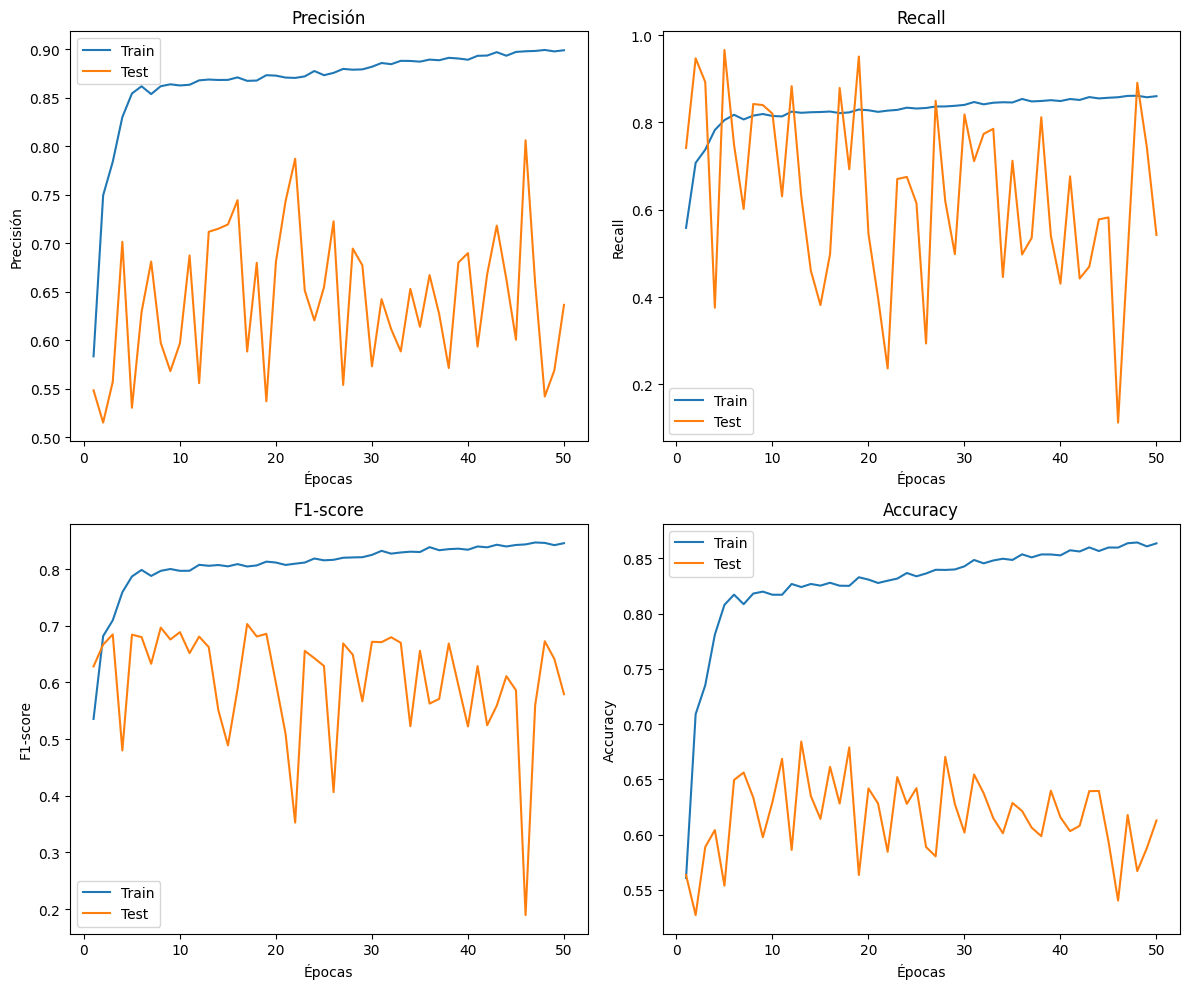

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz")
epochs = data['epochs']
precision_train = data['precision_train']
recall_train = data['recall_train']
f1_train = data['f1_train']
accuracy_train = data['accuracy_train']
precision_test = data['precision_test']
recall_test = data['recall_test']
f1_test = data['f1_test']
accuracy_test = data['accuracy_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')
plt.tight_layout()
plt.show()

# Generación de una imagen del cifar 100 pedida por el usuario

Tamaño imagen generada:  (1, 32, 32, 3)


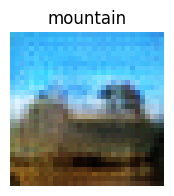

In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image

noise_dim = 100 # Dimension del ruido

tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
def get_index(word, tags_list):
    try:
        return tags_list.index(word)
    except ValueError:
        return -1  # Devuelve -1 si la palabra no se encuentra en la lista

# Cargar el modelo generador
g_model = load_model('gmodel_m4_cifar100.h5')

imagen_a_generar = 'mountain'
index = get_index(imagen_a_generar, tags)

#label = tf.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10
label = tf.ones(1)*index

# Generar ruido aleatorio
noise = tf.random.normal(shape=(1, noise_dim))

# Generar imagen falsa
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])
print("Tamaño imagen generada: ", generated_image.shape)

plt.figure(figsize=(2,2))
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"{tags[index]}")
plt.show()